In [1]:
'''For preprocessing images'''
import numpy as np
from PIL import Image
import scipy
import matplotlib.pyplot as plt
import csv
import glob

## Commands for the neccessary dependencies below:
- pip install keras
- pip install tensorflow
- pip install --upgrade numpy

In [2]:
'''For CNN'''
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
from matplotlib.pyplot import imshow

Using TensorFlow backend.


## Preprocessing image data:
- I start by standardizing all the images so that they are of the same size 
- Basically I just take the longer size and pad the shorter side to give me a square.
- Then, i resize the image to the size that I desire.

In [3]:
def view_standardized(img):
    # padding
    longer_side = max(img.size)
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    img = img.crop(
        (
            -horizontal_padding,
            -vertical_padding,
            img.size[0] + horizontal_padding,
            img.size[1] + vertical_padding
        )
    )
    # resizing to standardized size
    img = img.resize([200,200],Image.ANTIALIAS) 
    plt.imshow(img) # To see the image being standardized.
    return 

In [14]:
image_size = 96
train_data_size = 4000
test_data_size = 1000

## Checking images:
- I displayed the first 3 images.
- From the pictures, we can be assured that they are processed correctly.

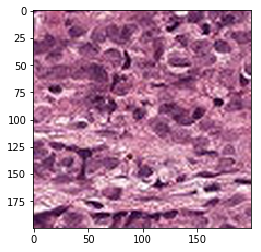

In [4]:
img =Image.open('input/subset_data/train/00bd66215347594c235b77beda5cd30ab75c0f0c.tif')
img = view_standardized(img)

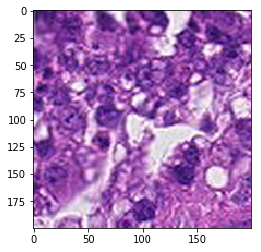

In [5]:
img =Image.open('input/subset_data/train/0a47d53ab3d01e5e49ffa038ff1e272de21fac7b.tif')
img = view_standardized(img)

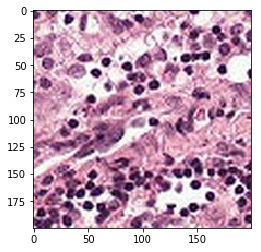

In [6]:
img =Image.open('input/subset_data/train/0b3f6cb0092e8a2e88743cfc37b8602ebf8533a2.tif')
img = view_standardized(img)

## Further preprocessing:
- To use the images as inputs for the neual networks, I need them in matrix form.
- So below, an extra few steps are added to do that.
- For the shape of the matrix, I have selected it to be 200 x 200 x 3.
- Think of it as a square of 200 by 200 pixels.
- Each pixel can take 3 primary colors (red, blue and green).
- This gives us 200 x 200 x 3.
- Note that the dimensionals are just something that I have chosen.
- Dimensionals can be adjusted and played with.

In [15]:
def standardize(img):
    # padding
    longer_side = max(img.size)
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    img = img.crop(
        (
            -horizontal_padding,
            -vertical_padding,
            img.size[0] + horizontal_padding,
            img.size[1] + vertical_padding
        )
    )
    # resizing to standardized size
    img = img.resize([image_size,image_size],Image.ANTIALIAS) \
    # plt.imshow(img) # To see the image being standardized.
    
    # converting image to numpy array
    img.load()
    img = np.asarray(img, dtype="int32")
    return img

## To double check the dimensions of my image input:

In [16]:
def function():
    for filename in glob.glob('input/subset_data/train/*.tif'):
        img =Image.open(filename)
        img = standardize(img)
        print(img.shape)
        return

In [17]:
function()

(96, 96, 3)


## Loading data:
- Next, we want to load our train and test data using our preprocessing function above.
- The only issue is matching the corresponding output to the image.
- I looped through all rows in csv inputs and match them appropriately.

In [18]:
def get_id_from_filename(filename):
    id = filename.split("/")[-1]
    id = id.split(".")[0]
    return id

In [19]:
def load_train():
    names = []
    X_train = np.empty((train_data_size,image_size,image_size,3), dtype="int32")
    Y_train = np.empty(shape=(train_data_size,2),dtype="int32")

    i = 0
    for filename in glob.glob('input/subset_data/train/*.tif'):
        names.append(get_id_from_filename(filename))
        img =Image.open(filename)
        img = standardize(img)
        X_train[i-1] = img
        i += 1
        
    with open('input/subset_data/train_labels_full.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV, None)
        for row in readCSV:
            name = row[0]
            if name in names:
                label = int(row[1])
                if label == 0:
                    Y_train[names.index(name)] = np.array([1,0]) # means 0
                elif label == 1:
                    Y_train[names.index(name)] = np.array([0,1]) # means 1
    return X_train,Y_train

In [20]:
def load_test():
    names = []
    X_test = np.empty((test_data_size,image_size,image_size,3), dtype="int32")
    Y_test = np.empty(shape=(test_data_size,2),dtype="int32")

    i = 0
    for filename in glob.glob('input/subset_data/test_with_outputs/*.tif'):
        names.append(get_id_from_filename(filename))
        img =Image.open(filename)
        img = standardize(img)
        X_test[i-1] = img
        i += 1
        
    with open('input/subset_data/train_labels_full.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV, None)
        for row in readCSV:
            name = row[0]
            if name in names:
                label = int(row[1])
                if label == 0:
                    Y_test[names.index(name)] = np.array([1,0]) # means 0
                elif label == 1:
                    Y_test[names.index(name)] = np.array([0,1]) # means 1
    return X_test,Y_test

In [31]:
X_train, Y_train = load_train()
X_test, Y_test = load_test()
X_train = X_train/255.
X_test = X_test/255.
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (4000, 96, 96, 3)
Y_train shape:  (4000, 2)
X_test shape:  (1000, 96, 96, 3)
Y_test shape:  (1000, 2)


In [34]:
# To check values inside.
#print(X_train)
#print(Y_train)
#print(X_test)
#print(Y_test)

## CNN model design:
- Before looking at the design, have a read about the basics of CNN [here](https://vinodsblog.com/2018/10/15/everything-you-need-to-know-about-convolutional-neural-networks/) and [here](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/).
- **Input:** input_shape which is the dimensions of our image.
- **Output:** CNN model
- Summary of model design is dislayed below.

In [35]:
def TrainingModel(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(8, (4, 4), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((8, 8), name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (2, 2), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(2, activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='trainingModel')

    return model

In [36]:
trainingModel = TrainingModel((X_train.shape[1],X_train.shape[2],X_train.shape[3]))

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
trainingModel.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

## If on server:
- Set epochs to 40 and try.
- I am doing a small amount 5 as I am on a CPU.
- I suspect >0.9 accuracy is definitely possible.
- Likewirse, evaluation on test data would also improve.

In [39]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

trainingModel.fit(x = X_train, y = Y_train, epochs = 50, batch_size = 32, validation_data=(X_test,Y_test),callbacks=[reducel, earlystopper])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 497us/step - loss: 0.6503 - acc: 0.6190 - val_loss: 0.7027 - val_acc: 0.5440
Epoch 2/50
4000/4000 [==============================] - 2s 454us/step - loss: 0.6500 - acc: 0.6265 - val_loss: 0.7107 - val_acc: 0.5850

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/50
4000/4000 [==============================] - 2s 440us/step - loss: 0.6378 - acc: 0.6402 - val_loss: 0.7006 - val_acc: 0.5520
Epoch 4/50
4000/4000 [==============================] - 2s 437us/step - loss: 0.6307 - acc: 0.6555 - val_loss: 0.6953 - val_acc: 0.5650
Epoch 5/50
4000/4000 [==============================] - 2s 427us/step - loss: 0.6314 - acc: 0.6515 - val_loss: 0.6949 - val_acc: 0.5590
Epoch 6/50
4000/4000 [==============================] - 2s 426us/step - loss: 0.6299 - acc: 0.6502 - val_loss: 0.7008 - val_acc: 0.5490

Epoch 00006: ReduceLROnPlateau reducing learning rate

In [40]:
preds = trainingModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 0s 200us/step

Loss = 0.6948882160186768
Test Accuracy = 0.559


In [41]:
trainingModel.predict(X_test)

array([[0.55592656, 0.4440734 ],
       [0.5623026 , 0.43769744],
       [0.59535414, 0.40464583],
       ...,
       [0.5586803 , 0.44131973],
       [0.5919302 , 0.4080698 ],
       [0.6645371 , 0.3354629 ]], dtype=float32)

In [ ]:
# Summary of the CNN model used.
trainingModel.summary()

## We now move to attempting transfer learning:
- A simple guide to read [here](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e).
- Read the first part before they introduce the code.

## Applying transfer learning (VGG16)
- Using pre-trained weights from VGG model
- freeze all the layers and only train the last 3 layers
- Should give a better accuracy

In [ ]:
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

In [ ]:
# checking the type
type(vgg16_model)

In [ ]:
vgg16_model.summary()

In [ ]:
# Create your own input format (here 200x200x3)
X_input = Input(shape=(200,200,3),name = 'image_input')

In [ ]:
output_vgg16_conv = vgg16_model(X_input)

In [ ]:
# Add the fully-connected layers 
X = Flatten(name='flatten')(output_vgg16_conv)
X = Dense(2048, activation='relu', name='fc1')(X)
X = Dense(2048, activation='relu', name='fc2')(X)
X = Dense(2, activation='softmax', name='predictions')(X)

In [ ]:
my_model = Model(inputs=X_input, outputs=X,name='myModel')

In [ ]:
my_model.summary()

In [ ]:
my_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

## If on server:
- Set epochs to 5-10 and try.
- I am doing a small amount (1 only...) as I am on a CPU.
- I suspect higher accuracy is definitely possible.

## Another possibility:
- Our actual training data set is much bigger than 450.
- We can unfreeze more layers and train it to attain better results.

In [ ]:
my_model.fit(x = X_train, y = Y_train, epochs = 1, batch_size = 32, validation_data=(X_test,Y_test))

In [ ]:
preds = my_model.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

## <span style="color:red">*Note:*</span>
- From this point onwards, it is too computationally intensive and requires a GPU.
- I did not run on my computer but wrote the code for it.
- There might be some minor bugs in the code as I didn't get to run it.

## Applying transfer learning (InceptionV3)
- Using pre-trained weights from VGG model
- freeze all the layers and only train the last 3 layers
- Should give a better accuracy

In [ ]:
inceptionV3_model = keras.applications.inception_v3.InceptionV3(weights='imagenet',include_top=False)

In [ ]:
type(inceptionV3_model)

In [ ]:
inceptionV3_model.summary()

In [ ]:
# Freeze all the other layers, let last few layers to be trainable
for layer in inceptionV3_model.layers[:290]:
    layer.trainable = False

In [ ]:
inceptionV3_model.summary()

In [ ]:
# Create your own input format (here 200x200x3)
X_input = Input(shape=(200,200,3),name = 'image_input')

In [ ]:
output_inceptionV3_conv = inceptionV3_model(X_input)

### Reference:
- https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
- I just followed whatever they recommended.

In [ ]:
# keras recommended application
X = GlobalAveragePooling2D()(output_inceptionV3_conv)
X = Dense(1024, activation='relu')(X)
X = Dense(4, activation='softmax', name='predictions')(X)

In [ ]:
my_model = Model(inputs=X_input, outputs=X,name='myModel')

In [ ]:
my_model.summary()

In [ ]:
my_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
my_model.fit(x = X_train, y = Y_train, epochs = 3, batch_size = 32, validation_data=(X_test,Y_test))

In [ ]:
preds = my_model.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

## Applying transfer learning (ResNet50)
- Using pre-trained weights from VGG model
- freeze all the layers and only train the last 3 layers
- Should give a better accuracy
- Suspected to perform the worst... (might need to confirm)

In [ ]:
# To resolve the issue of BN in keras layers
K.set_learning_phase(1)

In [ ]:
resnet50_model = keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)

In [ ]:
type(resnet50_model)

In [ ]:
resnet50_model.summary()

In [ ]:
# Freeze all the other layers
for layer in resnet50_model.layers:
    layer.trainable = False

In [ ]:
# Create your own input format (here 200x200x3)
X_input = Input(shape=(200,200,3),name = 'image_input')

In [ ]:
output_resnet50_conv = resnet50_model(X_input)

In [ ]:
X = GlobalAveragePooling2D()(output_resnet50_conv)
# X = Dense(4, activation='softmax', name='predictions')(X)
X = Flatten(name='flatten')(output_resnet50_conv)
X = Dense(2048, activation='relu', name='fc1')(X)
X = Dropout(0.7)(X)
X = Dense(1024, activation='relu', name='fc2')(X)
X = Dropout(0.7)(X)
X = Dense(4, activation='softmax', name='predictions')(X)

In [ ]:
my_model = Model(inputs=X_input, outputs=X,name='myModel')

In [ ]:
my_model.summary()

In [ ]:
my_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
my_model.fit(x = X_train, y = Y_train, epochs = 3, batch_size = 32, validation_data=(X_test,Y_test))

In [ ]:
preds = my_model.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))